# **Optimal Strategy for Playing "Bank"**
## **Author:** Tanner Rapp


### What the program does

This program simulates a 20-round dice game called Bank thousands of times to estimate each player’s chances of winning under fixed “optimal strategy” thresholds. Each player has an individual banking threshold—the minimum shared pot required before they automatically lock in their points and exit the round. The simulation repeatedly plays full games, tracks how much each player banks across the rounds, and records who wins each game (splitting wins in the case of ties). After running many simulations, the program aggregates the results into a win-rate for each player and then visualizes those estimated probabilities in a bar chart. This allows you to explore how different threshold strategies influence long-term performance in a randomized game setting.

### Rules

Goal: After 20 rounds, whoever has the most points wins.

How a round works

• Players take turns rolling two dice.

• You can choose to bank on your turn. Banking means you lock in your current points for that round and stop rolling.

• A round ends in one of two ways:

 1. Someone rolls a 7 after the third roll of the round, or

 2. Every player chooses to bank.


Special rules

• Rolling a 7 in the first three rolls: instead of ending the round, it adds 70 points to the bank (the shared pot for the round).

• Rolling a 7 after the third roll: this ends the round and whoever banked their points keeps them; anyone who didn’t bank loses what they hadn’t locked in.


• Doubles (like 3–3, 5–5, etc.):

 – If this happens after the third roll, the entire bank doubles.

 – If it happens within the first three rolls, it just counts as the normal total (like 6 for double 3s).


Scoring

• The bank is the shared pot players are trying to grab points from by banking before the round ends.

• When you bank, you take the current bank amount as your points for that round and you’re done rolling.

• After 20 rounds, the highest total score wins.

In [1]:
import random
import pandas as pd

# List of players in turn order
players = [
    'Alice', 'Bob', 'Charlie', 'Diana', 'Eve',
    'Frank', 'Grant', 'Hugh', 'Ivy', 'Jack',
    'Kevin', 'Liam', 'Mia', 'Nina', 'Owen', 'Paul'
]

# Banking thresholds:
# A player can only bank (lock in points) once the shared bank
# is greater than or equal to their individual threshold.
bank_thresholds = {
    'Alice': 100,
    'Bob': 150,
    'Charlie': 200,
    'Diana': 250,
    'Eve': 300,
    'Frank': 350,
    'Grant': 400,
    'Hugh': 450,
    'Ivy': 500,
    'Jack': 600,
    'Kevin': 700,
    'Liam': 800,
    'Mia': 900,
    'Nina': 1000,
    'Owen': 1500,
    'Paul': 2000
}


def log_round(round_num, players, bank_accounts, log_df):
    """
    Log the cumulative banked points for each player at the end of a round.

    Parameters
    ----------
    round_num : int
        The current round number (1-based).
    players : list of str
        Ordered list of player names.
    bank_accounts : dict
        Mapping from player name -> total banked points so far.
    log_df : pd.DataFrame
        DataFrame tracking cumulative points per round.

    Returns
    -------
    pd.DataFrame
        Updated log_df with one additional row for this round.
    """
    # Create a row with the round number and each player's current total
    row = {"round": round_num}
    for p in players:
        row[p] = bank_accounts[p]

    # Append as a new row to the log DataFrame
    return pd.concat([log_df, pd.DataFrame([row])], ignore_index=True)


def bank_game(players, num_rounds=20):
    """
    Simulate the Bank dice game for a fixed number of rounds.

    Game summary (as implemented here)
    ----------------------------------
    - There is a shared bank of points that grows during each round.
    - At the start of each round, all players are 'active'.
    - Before any rolls in a loop, any active player whose individual
      threshold is reached (shared_bank >= bank_thresholds[player])
      automatically banks:
        * They add the current shared_bank to their personal total.
        * They are removed from the round (no more rolls or banking).
      (Multiple players can bank off the same shared_bank value.)
    - A round ends when:
        1. All players have banked (no active players left), OR
        2. Someone rolls a 7 after the third roll of the round.

    Dice rules
    ----------
    - Each roll uses two six-sided dice.
    - total_rolls_in_round counts how many dice rolls have occurred
      in the current round (across all players).
    - First 3 rolls of a round:
        * If sum == 7: add 70 to shared_bank (round continues).
        * Else: add the sum of the dice to shared_bank.
    - After the 3rd roll:
        * If sum == 7:
            - The round ends immediately.
            - shared_bank is reset to 0 (nobody banks at this moment).
        * Else if the dice are doubles (die1 == die2):
            - shared_bank is doubled.
        * Else:
            - Add the sum of the dice to shared_bank.

    Turn order
    ----------
    - The starting player rotates each round using start_index.
    - Within a round, players roll in that rotated order, skipping
      any players who have already banked.

    Parameters
    ----------
    players : list of str
        Names of players participating in the game.
    num_rounds : int, optional
        Number of rounds to play (default is 20).

    Returns
    -------
    bank_accounts : dict
        Mapping from player name -> total points after all rounds.
    log_df : pd.DataFrame
        Log of cumulative totals for each round.
    """

    # Initialize each player's total banked points to 0
    bank_accounts = {p: 0 for p in players}

    # DataFrame to log cumulative totals at the end of each round
    log_df = pd.DataFrame(columns=["round"] + players)

    n_players = len(players)
    shared_bank = 0          # Shared pot for the current round
    round_num = 1            # Current round number
    start_index = 0          # Index of the player who starts the round

    # Main game loop over rounds
    while round_num <= num_rounds:
        # All players start active at the beginning of a round
        active_players = set(players)

        # Count how many total rolls have happened in this round
        total_rolls_in_round = 0

        # Determine rolling order for this round, rotated by start_index
        order = [players[(start_index + i) % n_players] for i in range(n_players)]

        round_ended = False

        # Loop until something ends the round
        while not round_ended:
            # 1) BANKING PHASE
            # Before any rolls in this loop, allow any active player whose
            # threshold is met to bank and leave the round.
            to_remove = []

            for player in list(active_players):
                # If the shared bank is at or above this player's threshold,
                # they bank the current shared_bank and exit the round.
                if shared_bank >= bank_thresholds[player]:
                    bank_accounts[player] += shared_bank
                    to_remove.append(player)

            # Remove all players who just banked from the active set
            for player in to_remove:
                active_players.remove(player)

            # If everyone has banked, the round ends.
            if not active_players:
                log_df = log_round(round_num, players, bank_accounts, log_df)
                shared_bank = 0
                round_num += 1
                # Rotate who starts the next round
                start_index = (start_index + 1) % n_players
                break  # Exit the inner while not round_ended loop

            # 2) ROLLING PHASE
            # Players roll in the current order as long as the round continues.
            for player in order:
                # Skip players who have already banked and left the round
                if player not in active_players:
                    continue

                # Roll two six-sided dice
                die1 = random.randint(1, 6)
                die2 = random.randint(1, 6)
                s = die1 + die2
                total_rolls_in_round += 1

                # First 3 rolls of the round
                if total_rolls_in_round <= 3:
                    if s == 7:
                        # 7 in the first three rolls: add 70, round continues
                        shared_bank += 70
                    else:
                        # Otherwise, just add the sum of the dice
                        shared_bank += s

                # After the 3rd roll
                else:
                    if s == 7:
                        # 7 after third roll:
                        # - round ends immediately
                        # - bank is wiped to 0 (no banking at this roll)
                        log_df = log_round(round_num, players, bank_accounts, log_df)
                        shared_bank = 0
                        round_num += 1

                        # Next round starts with the player after the one
                        # who just rolled the 7.
                        start_index = (players.index(player) + 1) % n_players
                        round_ended = True
                        break  # Break out of the for player in order loop
                    else:
                        # Not a 7 after the 3rd roll
                        if die1 == die2:
                            # Doubles after the 3rd roll -> double the bank
                            shared_bank *= 2
                        else:
                            # Otherwise, add the sum to the bank
                            shared_bank += s

    return bank_accounts, log_df


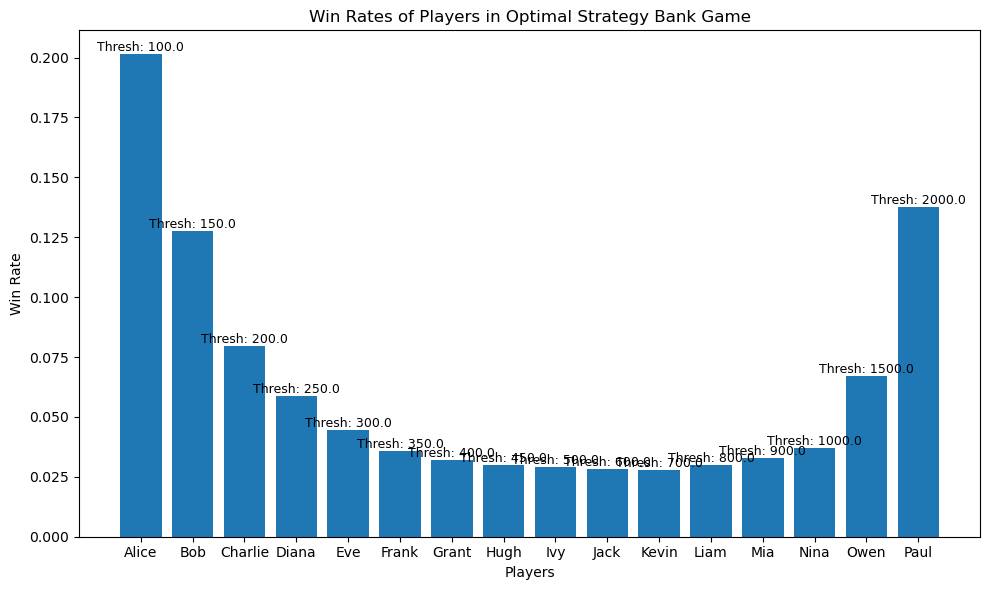

In [2]:
import matplotlib.pyplot as plt

# Number of simulated games to run
n_simulations = 10000

# Track wins (or fractional wins for ties) for each player
wins = {p: 0 for p in players}

# Run the simulations
for _ in range(n_simulations):

    # Play one full 20-round game
    bank_accounts, log_df = bank_game(players, num_rounds=20)

    # Highest score at the end of the game
    max_balance = max(bank_accounts.values())

    # One game can have multiple winners (ties)
    winners = [p for p, v in bank_accounts.items() if v == max_balance]

    # If players tie, each gets an equal share of a “win”
    share = 1 / len(winners)
    for w in winners:
        wins[w] += share


# Convert results into a DataFrame for easy plotting
wins_df = pd.DataFrame.from_dict(wins, orient='index', columns=['wins'])

# Win rate = fraction of simulations where the player won
wins_df['win_rate'] = wins_df['wins'] / n_simulations

# Add each player’s threshold for labeling on the plot
wins_df['threshold'] = [bank_thresholds[p] for p in wins_df.index]


# --------------------------- PLOTTING ---------------------------

plt.figure(figsize=(10, 6))
plt.bar(wins_df.index, wins_df['win_rate'])

plt.title('Win Rates of Players in Optimal Strategy Bank Game')
plt.xlabel('Players')
plt.ylabel('Win Rate')

# Annotate each bar with the player's threshold value
for i, row in wins_df.iterrows():
    plt.text(
        x=i,
        y=row['win_rate'],              # anchor at the top of the bar
        s=f"Thresh: {row['threshold']}",
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()


### Graph explanation & statistical interpretation

The graph shows that players with very low thresholds win most often because they bank early and avoid risk. Win rates drop steadily for mid-range thresholds, since those players take on more risk without gaining much extra reward. At the highest thresholds, win rates rise again because these players occasionally capture extremely large pots (giving them a “high-risk, high-reward” edge). Statistically, this creates a U-shaped pattern, resembling a bimodal distribution, where both very conservative and very aggressive strategies outperform the middle.